In [1]:
import pandas as pd
import numpy as np
import pydot
from PIL import Image
from io import BytesIO
from IPython.display import display

## Decision Tree Regressor

In [2]:
class Node_reg:
    """
    Initializes "Node class constructor" for regression problems which stores and initialises:
    Feature index used for best split :  feature = None,
    Left child node :  left_spl = None,
    Right child node :  right_spl = None,
    Node Splitting threshold value :  spl_val = None,
    Variance loss value:  var_redn = None,
    Output value of the node :  out_val = None

    """

    def __init__(
        self,
        feature=None,
        spl_val=None,
        left_spl=None,
        right_spl=None,
        var_redn=None,
        *,
        out_val=None
    ):
        self.feature = feature
        self.threshold = spl_val
        self.left = left_spl
        self.right = right_spl
        self.var_redn = var_redn
        self.output = out_val

    # function to check whether a leaf node or not
    def is_leaf_node(self):
        return self.output is not None


In [3]:
class DecisionTreeRegressor:
    """
    Initializes "Decision Tree constructor" for regression problems which stores and initialises:
    Maximum tree depth : max_depth=100,
    Minimum samples reuqired for splitting nodes : min_samples_split=2,
    Number of features to be used for tree: n_features = None,
    Cost function/ Loss criterion for splitting nodes : criterion='mse'

    """

    def __init__(
        self, max_depth=100, min_samples_split=2, n_features=None, criterion="mse"
    ):

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.criterion = criterion
        self.root = None

    # # For storing tree structure to generate tree graph visualization
        self.tree = None

    """
  Defines the train method of the DecisionTree class, 
  which takes two inputs: 
  1. X, a matrix of input features
  2. y, a vector of output labels
  Then, uses the _build_tree function to proceed with growing the decision tree structure
  """

    def train(self, X, y):
        # sets self.n_features to number of features in the input if n_features is not specified,
        # Else, the minimum of n_features and the number of features in the input data if n_features is specified to avoid exceeding the maximum feature limit

        self.n_features = (
            X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        )
        self.root = self._build_tree(X, y)
        self.tree = self._tree_to_dict()

    """
  Defines the recursive "_build_tree" function of the DecisionTree class, 
  which takes two inputs: 
  1. X, a matrix of input features
  2. y, a vector of output labels

  Returns Tree Nodes after each iteration
  """

    def _build_tree(self, X, y, depth=0):
        # stores the number of observations and features in the input data
        n_obs, n_fts = X.shape

        # checks for stopping conditions of a decision tree, if met returns the leaf node
        if depth >= self.max_depth or n_obs <= self.min_samples_split:
            leaf_val = self._calculate_node_mean(y)
            return Node_reg(out_val=leaf_val)

        # checks for all possible splits across features and returns the best split threshold and feature column index
        best_var_redn = -float("inf")
        best_feature, best_thresh = None, None
        criterion = self.criterion

        # random selection of specified number of features out of all the available features
        select_fts = np.random.choice(n_fts, self.n_features, replace=False)

        for feature in select_fts:
            thresholds = np.unique(X[:, feature])
            for thresh in thresholds:
                var_redn = self._variance_reduction(y, X[:, feature], thresh, criterion)
                if var_redn > best_var_redn:
                    best_var_redn = var_redn
                    best_feature = feature
                    best_thresh = thresh

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._build_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node_reg(
            feature=best_feature,
            spl_val=best_thresh,
            left_spl=left,
            right_spl=right,
            var_redn=best_var_redn,
        )

    """
  Defines the function to compute leaf node value 
  which takes input as y, a vector of output labels and returns the mean
  """

    def _calculate_node_mean(self, y):
        """ """
        val = np.mean(y)
        return val

    """
  Defines the node splitting function which takes as input
  data : the subset input data based on a feature index
  split_thresh : Specified split threshold to split the tree in left and right child nodes

  Returns : Indices of left and right child nodes
  """

    def _split(self, data, split_thresh):
        left_idxs = np.argwhere(data <= split_thresh).flatten()
        right_idxs = np.argwhere(data > split_thresh).flatten()
        return left_idxs, right_idxs

    """
  Defines the information_gain funtion which takes as input
  y_parent : Parent node data for labels
  X_ft : the subset input data based on a feature index
  split_thresh : Specified split threshold to split the tree in left and right child nodes
  criterion : Criterion to calculate node impurity values, mean-squared-error or mean-absolute-error for regression tasks

  Returns : Information gain value, which is variance reduction for regression, as we move from a parent node to child nodes
  """

    def _variance_reduction(self, y_parent, X_ft, threshold, criterion):
        if criterion.lower() == "mse":
            # parent entropy
            parent_mse = self._mse_loss(y_parent)

            # create children
            left_idxs, right_idxs = self._split(X_ft, threshold)
            if len(left_idxs) == 0 or len(right_idxs) == 0:
                return 0

            # calculate the weighted avg. entropy of children
            n = len(y_parent)
            p_left, p_right = len(left_idxs) / n, len(right_idxs) / n
            e_left, e_right = self._mse_loss(y_parent[left_idxs]), self._mse_loss(
                y_parent[right_idxs]
            )

            child_mse = p_left * e_left + p_right * e_right

            # calculate the IG
            information_gain = parent_mse - child_mse

        elif criterion.lower() == "mae":
            # parent gini impurity
            parent_mae = self._mae_loss(y_parent)

            # create children
            left_idxs, right_idxs = self._split(X_ft, threshold)
            if len(left_idxs) == 0 or len(right_idxs) == 0:
                return 0

            # calculate the weighted avg. gini impurity of children
            n = len(y_parent)
            p_left, p_right = len(left_idxs) / n, len(right_idxs) / n
            g_left, g_right = self._mae_loss(y_parent[left_idxs]), self._mae_loss(
                y_parent[right_idxs]
            )

            child_mae = p_left * g_left + p_right * g_right

            # calculate the IG
            information_gain = parent_mae - child_mae

        else:
            information_gain = -1

        return information_gain

    """
  Defines the MSE_loss function which takes as input
  y_parent : data of label for a node

  Returns : Mean squared error of the node
  """

    def _mse_loss(self, y):
        n = len(y)
        m = np.mean(y)
        return np.sum(np.square(y - m)) / n

    """
  Defines the MAE_loss function which takes as input
  y_parent : data of label for a node

  Returns : Mean absolute error of the node
  """

    def _mae_loss(self, y):
        n = len(y)
        m = np.mean(y)
        return np.sum(np.abs(y - m)) / n

    """
  Defines the predict method of the Decision Tree Regressor which takes as input
  X : Test/ Valdiation dataset for features

  Returns : Array of Prediction classes after traversing through each observation or row in "X"
  """

    def predict(self, X):
        return np.array([self._traverse_dtree(x, self.root) for x in X])

    """
  Defines the recursive "_traverse_dtree" function which takes as input
  x : one single row/ observation of the test/validation data
  node : information of parent node to traverse down the tree to leaf
  """

    def _traverse_dtree(self, x, node):

        # Checks for leaf node, if satisfied returns the node output value, else keeps on traversing
        if node.is_leaf_node():
            return node.output

        # Checks if observation has the feature with value according to left child node (<= threshold) and keeps on traversing in the left splits
        if x[node.feature] <= node.threshold:
            return self._traverse_dtree(x, node.left)

        # Finally traverses on the right child node
        return self._traverse_dtree(x, node.right)

    """
    Defines the recursive "print_tree" function which returns the text print of the trained decision tree
  """

    def print_tree(self, tree=None, indent=" "):
        """function to print the tree"""
        if not tree:
            tree = self.root

        if tree.output is not None:
            print(tree.output)

        else:
            print(
                "X_" + str(tree.feature),
                "<=",
                tree.threshold,
                "?",
                round(tree.var_redn, 4),
            )
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    """
  Defines the recursive "_tree_to_dict" function which returns the dictionary of nodes of the trained decision tree
  """

    def _tree_to_dict(self, tree=None):
        """function to convert tree to dictionary"""
        if not tree:
            tree = self.root

        if tree.output is not None:
            return tree.output

        else:
            left = self._tree_to_dict(tree.left)
            right = self._tree_to_dict(tree.right)

        return {
            "feature": "X_" + str(tree.feature),
            "threshold": tree.threshold,
            "var_redn": round(tree.var_redn, 4),
            "left": left,
            "right": right,
        }

    """
  Defines the "visualize_tree" function which returns tree diagram of trained decision tree
  """

    def visualize_tree(self):
        graph = pydot.Dot(graph_type="digraph")
        tree_dict = self.tree
        split_index = [0]  # List to keep track of split index

        def add_node(node_dict):
            node_label = f"{node_dict['feature']} <= {node_dict['threshold']}"
            node = pydot.Node(node_label)
            graph.add_node(node)

            if isinstance(node_dict["left"], dict):
                left_node = add_node(node_dict["left"])
                graph.add_edge(pydot.Edge(node, left_node, label="True"))
            else:
                lbl_l = str(round(node_dict["left"], 4))
                leaf_node_label = f"Leaf-{split_index[0]} \n Value -> {lbl_l} \n"
                split_index[0] += 1  # Increment split index
                leaf_node = pydot.Node(
                    leaf_node_label, shape="box", style="filled", fillcolor="lightgreen"
                )
                graph.add_node(leaf_node)
                graph.add_edge(pydot.Edge(node, leaf_node, label="True"))

            if isinstance(node_dict["right"], dict):
                right_node = add_node(node_dict["right"])
                graph.add_edge(pydot.Edge(node, right_node, label="False"))
            else:
                lbl_r = str(round(node_dict["right"], 4))
                leaf_node_label = f"Leaf-{split_index[0]} \n Value -> {lbl_r} \n"
                split_index[0] += 1  # Increment split index
                leaf_node = pydot.Node(
                    leaf_node_label, shape="box", style="filled", fillcolor="lightblue"
                )
                graph.add_node(leaf_node)
                graph.add_edge(pydot.Edge(node, leaf_node, label="False"))

            return node

        add_node(tree_dict)
        Image.open(BytesIO(graph.create_png())).show()



## Testing on Dataset and comparison with SKLearn

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import tree
import time

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
X_train = diabetes_X[:-20]
X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
y_train = diabetes_y[:-20]
y_test = diabetes_y[-20:]

# Train the decision tree with mse method
tic = time.perf_counter()
reg = DecisionTreeRegressor(min_samples_split=50, max_depth=5, n_features = 55, criterion = 'mse')
reg.train(X_train, y_train)
toc = time.perf_counter()
print("Our DT")
print(f"Build time {toc - tic:0.4f} seconds")

predictions = reg.predict(X_test)

print("mean squared error : "+ str(np.sqrt(mean_squared_error(y_test, predictions))))
print("mean absolute error : "+ str(mean_absolute_error(y_test, predictions)))
print("r2 : "+ str(r2_score(y_test, predictions)))


#inbuilt dt
clf_i = tree.DecisionTreeRegressor()
clf_i.fit(X_train, y_train)
toc = time.perf_counter()
print("SKLearn DT")
print(f"Build time {toc - tic:0.4f} seconds")

predictions = clf_i.predict(X_test)
print("mean squared error : "+ str(np.sqrt(mean_squared_error(y_test, predictions))))
print("mean absolute error : "+ str(mean_absolute_error(y_test, predictions)))
print("r2 : "+ str(r2_score(y_test, predictions)))

Our DT
Build time 0.0547 seconds
mean squared error : 49.85788200101827
mean absolute error : 41.97347743426288
r2 : 0.4854634502629883
SKLearn DT
Build time 0.0596 seconds
mean squared error : 77.04101301952636
mean absolute error : 59.74714285714284
r2 : -0.22854918633927013


In [ ]:
reg.print_tree()

X_0 <= 0.004572166603000912 ? 1614.424
 left:X_0 <= -0.022373135244019075 ? 343.0206
  left:X_0 <= -0.039618128426111884 ? 83.0019
    left:X_0 <= -0.05901874575596628 ? 45.7289
        left:90.325
        right:103.8936170212766
    right:X_0 <= -0.02560657146566148 ? 83.6166
        left:X_0 <= -0.029917819761184662 ? 172.8322
                left:114.4
                right:146.36363636363637
        right:100.17647058823529
  right:X_0 <= -0.01913969902237667 ? 64.7502
    left:166.27272727272728
    right:X_0 <= -0.014828450726853487 ? 118.7599
        left:113.83333333333333
        right:X_0 <= -0.011595014505211082 ? 144.8945
                left:174.0909090909091
                right:140.25396825396825
 right:X_0 <= 0.0724743272574913 ? 744.1458
  left:X_0 <= 0.0175059114895705 ? 60.4795
    left:176.57142857142858
    right:X_0 <= 0.022894971858974496 ? 186.906
        left:233.08333333333334
        right:X_0 <= 0.04445121333659049 ? 112.2334
                left:177.857142

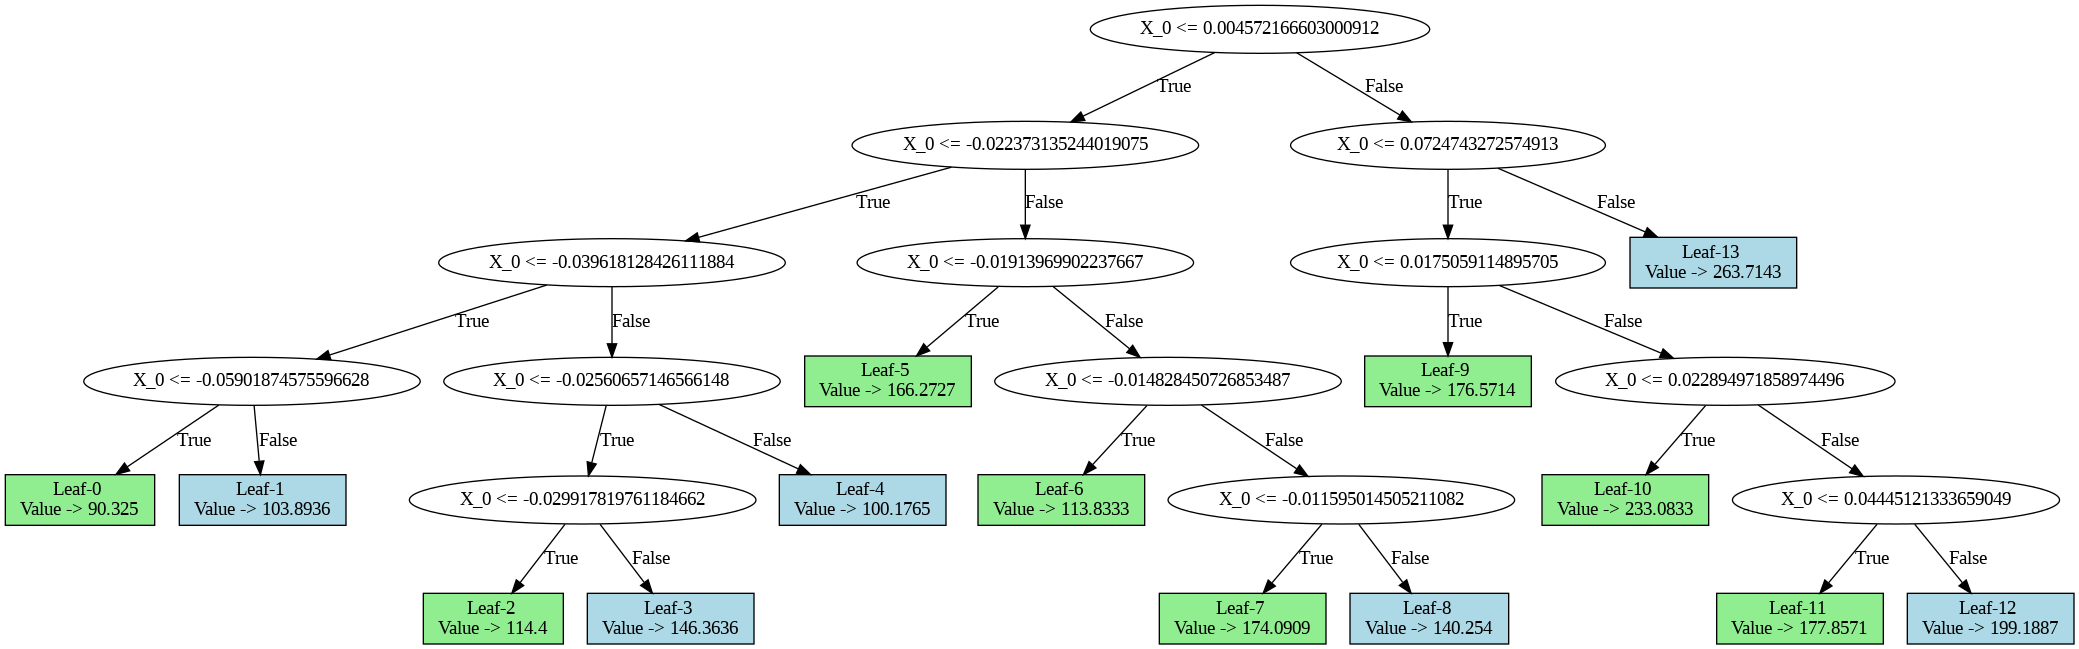

In [ ]:
reg.visualize_tree()

## Implenting the regressor DT to airbnb data

In [11]:
#We load the cleanedData csv which is the file that comes from doing the pre-processing(which takes some minutes to run so we just save it in the git.
df = pd.read_csv("CleanedData.csv")
df2 = df.drop(columns=['host_id', 'id', 'name', 'host_name', 'last_review']) #we drop the columns we are not using
df2=df2.dropna().reset_index(drop=True) # we drop na rows (only 1 row)
features = [col for col in df2.columns if col != "price"] #we define the features as all columns except price
target = df2["price"]

In [12]:
import sklearn

# Split data into training and testing sets
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df2[features], target, test_size=0.2, random_state=10)

#data is expected in numpy array format
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [13]:
tic = time.perf_counter()
reg = DecisionTreeRegressor(min_samples_split=50, max_depth=5, n_features = 55, criterion = 'mse')
reg.train(X_train, y_train)
toc = time.perf_counter()
print("Our DT")
print(f"Build time {toc - tic:0.4f} seconds")

predictions = reg.predict(X_test)

print("mean squared error : "+ str(np.sqrt(mean_squared_error(y_test, predictions))))
print("mean absolute error : "+ str(mean_absolute_error(y_test, predictions)))
print("r2 : "+ str(r2_score(y_test, predictions)))

#inbuilt dt
clf_i = tree.DecisionTreeRegressor()
clf_i.fit(X_train, y_train)
toc = time.perf_counter()
print("SKLearn DT")
print(f"Build time {toc - tic:0.4f} seconds")

predictions = clf_i.predict(X_test)
print("mean squared error : "+ str(np.sqrt(mean_squared_error(y_test, predictions))))
print("mean absolute error : "+ str(mean_absolute_error(y_test, predictions)))
print("r2 : "+ str(r2_score(y_test, predictions)))

Our DT
Build time 168.0722 seconds
mean squared error : 0.4338601578303653
mean absolute error : 0.32850167322929186
r2 : 0.5676821282828806
SKLearn DT
Build time 168.9311 seconds
mean squared error : 0.5620618508050855
mean absolute error : 0.4180120145532006
r2 : 0.27444244640614146
